# Brand sales analysis

In [973]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import xgboost as xgb

from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import r2_score

## Data preparation and analysis

Read data and check basic informations

In [974]:
data_df = pd.read_csv('data.csv', sep=';')
data_df.shape

(585, 25)

In [975]:
data_df.columns

Index(['Chain', 'Week', 'Brand1_SVOL', 'Brand1_SVAL', 'Brand1_WSD', 'MeanTemp',
       'WindChill', 'ShopNumber', 'Brand2_SVOL', 'Brand2_SVAL', 'Brand3_SVOL',
       'Brand3_SVAL', 'Brand4_SVOL', 'Brand4_SVAL', 'GRP_Brand1', 'GRP_Brand2',
       'GRP_Brand3', 'GRP_Brand4', 'Brand1_SBA', 'Brand2_SBA', 'Brand5_WSD',
       'Promo_Brand1', 'Promo_Brand2', 'Promo_Brand4', 'Season_dni_pracy'],
      dtype='object')

In [976]:
# Function to change commas in numbers to dots and save them as floats

def commas_to_float(df: pd.DataFrame,
                    column_name: str) -> pd.DataFrame:
    f = lambda x: float(x.replace(',', '.'))
    df[column_name] = df[column_name].apply(f)
    return df


The task is to analyze the Brand1, so we can assume that we can drop the others

In [977]:
columns = [
    'Chain', 'Week', 'Brand1_SVOL', 'Brand1_SVAL', 'Brand1_WSD', 'MeanTemp',
    'WindChill', 'ShopNumber', 'Brand1_SBA', 'Promo_Brand1', 'Season_dni_pracy',
    'GRP_Brand1'
]

brand1_df = data_df.loc[:,columns]

Change the names to clearer

In [978]:
brand1_dict = {
    'Brand1_SVOL': 'SVOL',
    'Brand1_SVAL': 'SVAL',
    'Brand1_WSD': 'WSD',
    'Brand1_SBA': 'SBA',
    'Promo_Brand1': 'Promo',
    'GRP_Brand1': 'GRP'
}

brand1_df.rename(columns=brand1_dict, inplace=True)
brand1_df.columns

Index(['Chain', 'Week', 'SVOL', 'SVAL', 'WSD', 'MeanTemp', 'WindChill',
       'ShopNumber', 'SBA', 'Promo', 'Season_dni_pracy', 'GRP'],
      dtype='object')

Check correlations between columns

In [979]:
commas_columns = [
    'SVOL',
    'SVAL',
    'WSD',
    'MeanTemp',
    'WindChill',
    'SBA',
    'ShopNumber',
    'GRP'
]

for col in commas_columns:
    brand1_df = commas_to_float(brand1_df, col)

<AxesSubplot:>

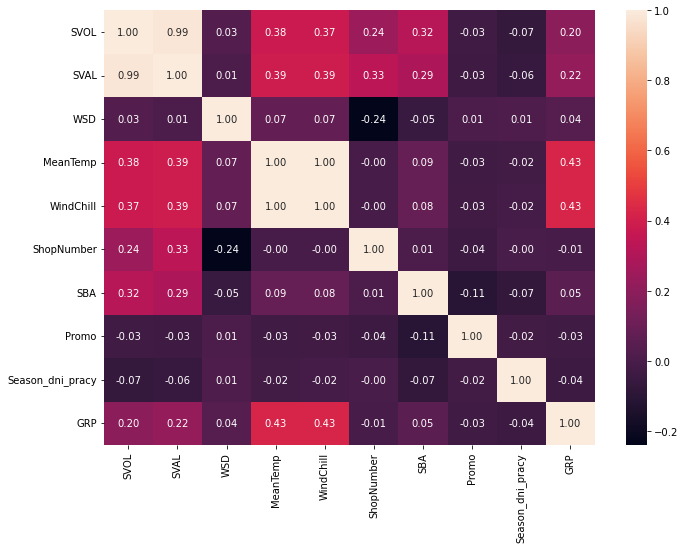

In [980]:
plt.figure(figsize=(11, 8))
corr = brand1_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f")

SVAL is highly correlated with SVOL as is WindChill with MeanTemp, so they can be dropped

In [981]:
to_drop = ['SVAL', 'WindChill']
brand1_df.drop(columns=to_drop, inplace=True)

Distributions of numerical variables

In [982]:
columns_list = brand1_df.columns.to_list()

columns_list.remove('Chain')
columns_list.remove('Week')

Conclusion:
 - increasing the GRP value will almost always result in an improvement in SVOL in the coming weeks.
 - usually, the greater the increase in GRP, the greater the increase in SVOL
 - In the long term, larger changes gain significance, while smaller ones lose them
 - due to the small number of data, anomalies occur (some negative values in week 2 or 4)

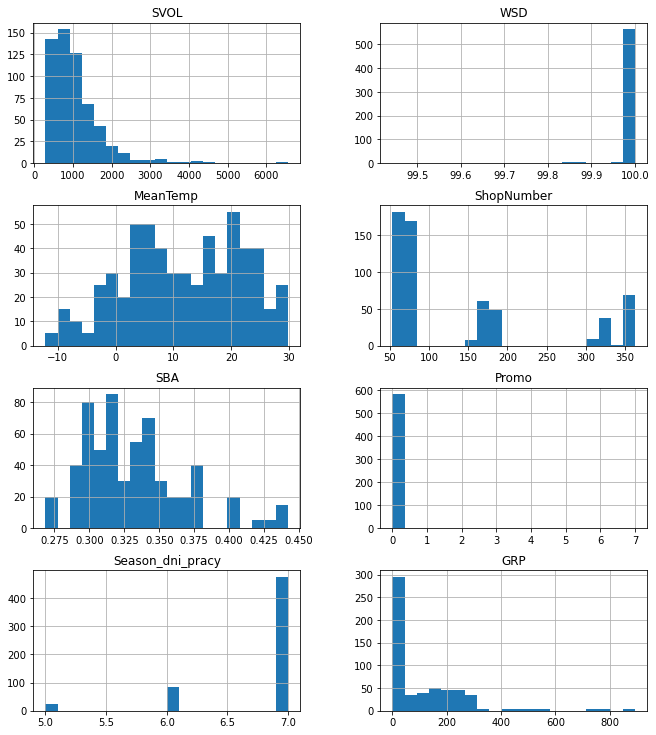

In [983]:
brand1_df[columns_list].hist(bins=20, figsize=(11, 100), layout=(30, 2))
plt.show()

The values of the WSD and Promo columns are nearly constant so we can drop them also


In [984]:
to_drop = ['WSD', 'Promo']
brand1_df.drop(columns=to_drop, inplace=True)

Prepare Chain and Week columns

In [985]:
f = lambda x: int(x[5:])
g = lambda x: int(x[6:])

brand1_df['Week'] = brand1_df['Week'].apply(f)  # rename values to ints
brand1_df['Chain'] = brand1_df['Chain'].apply(g)

brand1_df = pd.get_dummies(
    brand1_df,
    columns=['Chain']
)

Plot different chains at one figure

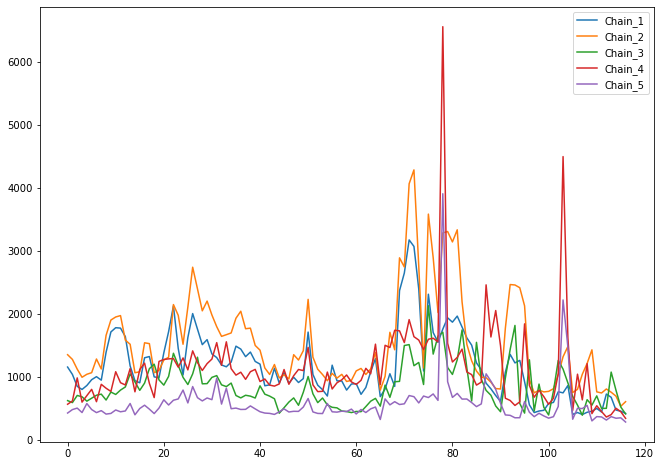

In [986]:
plt.figure(figsize=(11, 8))

x1 = brand1_df.loc[brand1_df.Chain_1 == 1].SVOL.plot()
x2 = brand1_df.loc[brand1_df.Chain_2 == 1].reset_index().SVOL.plot(ax=x1)
x3 = brand1_df.loc[brand1_df.Chain_3 == 1].reset_index().SVOL.plot(ax=x2)
x4 = brand1_df.loc[brand1_df.Chain_4 == 1].reset_index().SVOL.plot(ax=x3)
x5 = brand1_df.loc[brand1_df.Chain_5 == 1].reset_index().SVOL.plot(ax=x4)

plt.legend([f'Chain_{chain}' for chain  in range(1, 6)])
plt.show()

We can see specific trends in individual shops

## Base model

In [987]:
def validate_model(df: pd.DataFrame,
                   params: dict=None) -> None:
    if params is not None:
        model = xgb.XGBRegressor(
            learning_rate=params['learning_rate'],
            n_estimators=params['n_estimators'],
            min_child_weight=params['min_child_weight'],
            gamma=params['gamma'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            max_depth=params['max_depth'],
            scale_pos_weight=params['scale_pos_weight'],
            seed=13
        )
    else:
        model = xgb.XGBRegressor()
    
    # To not look ahead in tests we shoud sort data in time
    sorted_df = df.sort_values(by=['Week']).reset_index()
    cv = TimeSeriesSplit(5)

    pipe = Pipeline(steps=[
        ('scalar', StandardScaler()),  # standard becouse of args distributtion
        ('xgb', model)])

    scores = cross_val_score(pipe,
                            sorted_df.drop(columns=['Week', 'SVOL', 'index']),
                            sorted_df['SVOL'],
                            scoring='neg_mean_squared_error',
                            cv=cv)

    scores = np.sqrt(np.absolute(scores))
    print(f'Mean RMSE: {round(scores.mean(), 3)}')

In [988]:
validate_model(brand1_df)

Mean RMSE: 682.89


Base model is quite bad, lets try to make it better

## Feature engineering

Get data from previous weeks

In [989]:
for week in range(1, 5):
    brand1_df[f'GRP_{week}'] = brand1_df['GRP'].shift(periods=week)
    brand1_df[f'SVOL_{week}'] = brand1_df['SVOL'].shift(periods=week)
    brand1_df[f'SBA_{week}'] = brand1_df['SBA'].shift(periods=week)

# No data about GRP in previous weeks:    
brand1_df = brand1_df.loc[brand1_df['Week'] > 4]

In [990]:
def print_corrs(df: pd.DataFrame,
                prefix: str,
                cls: str) -> None:
    cols = [col for col in df if col.startswith(prefix)]
    print(df[cols].corrwith(df[cls]))

In [991]:
to_check = [
    'GRP_',
    'SVOL_',
    'SBA_'
]

for prefix in to_check:
    print_corrs(brand1_df, prefix, 'SVOL')

GRP_1    0.158437
GRP_2    0.166953
GRP_3    0.189676
GRP_4    0.200770
dtype: float64
SVOL_1    0.664038
SVOL_2    0.545170
SVOL_3    0.503842
SVOL_4    0.437894
dtype: float64
SBA_1    0.348887
SBA_2    0.349648
SBA_3    0.337481
SBA_4    0.312803
dtype: float64


In [992]:
validate_model(brand1_df)

Mean RMSE: 555.544



Adding this information significantly increased the effectiveness

## Parameterization of the model

In [993]:
params = {
    'max_depth': 12,
    'learning_rate': 0.005,
    'n_estimators': 1000,
    'min_child_weight': 8,
    'gamma': 0,
    'subsample': 0.5,
    'colsample_bytree': 0.6,
    'scale_pos_weight': 1
}


validate_model(brand1_df, params)

Mean RMSE: 485.859


A few random attempts gave a satisfactory improvement

## Anayzing the impact of GRP

Some basic functions

In [994]:
def create_pipe(params: dict) -> Pipeline:
    model = xgb.XGBRegressor(
            learning_rate=params['learning_rate'],
            n_estimators=params['n_estimators'],
            min_child_weight=params['min_child_weight'],
            gamma=params['gamma'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            max_depth=params['max_depth'],
            scale_pos_weight=params['scale_pos_weight'],
            seed=13
    )
    pipe = Pipeline(steps=[
        ('scalar', StandardScaler()),
        ('xgb', model)
    ])
    
    return pipe

In [995]:
def prepare_data(df: pd.DataFrame) -> list():
    srd = df.sort_values(by=['Week']).reset_index()

    X_train, X_test, y_train, y_test = train_test_split(
        srd.drop(columns=['Week', 'SVOL', 'index']),
        srd['SVOL'],
        test_size=0.2,
        shuffle=False  # we cant learn from future data
    )
    return X_train, X_test, y_train, y_test

In [996]:
def increase_GRP(period: int, 
                 value: int,
                 params: dict) -> None:
    
    pipe = create_pipe(params)
    X_train, X_test, y_train, _ = prepare_data(brand1_df)
    
    pipe.fit(X_train, y_train)
    X_test[f'GRP_{period}'] = X_test[f'GRP_{period}'].apply(lambda x: x+value)
    
    return np.median(pipe.predict(X_test))  # median is more reliable 
    

In [997]:
values = [10, 50, 100, 250, 500]
weeks = [x for x in range(1, 5)]

default_SVOL = increase_GRP(1, 0, params)
data = list()

for value in values:
    row = list()
    for week in weeks:
        row.append(increase_GRP(week, value, params))
    data.append(row)

<AxesSubplot:title={'center':'SVOL improvement for different GRP values'}>

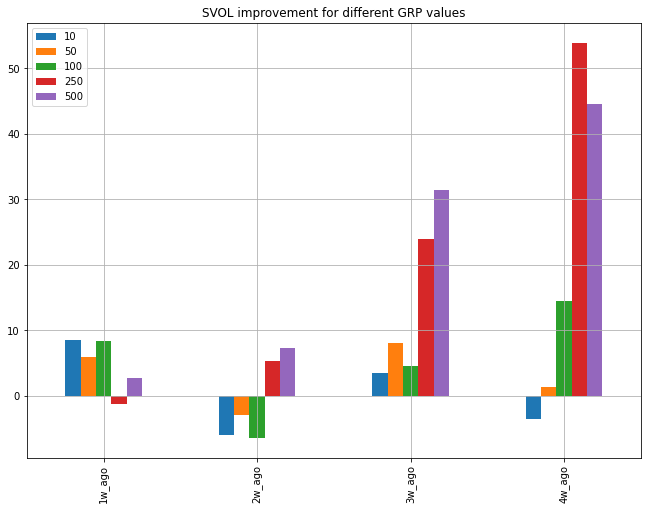

In [998]:
results = pd.DataFrame(
    data=data-default_SVOL,
    index=values,
    columns=[f'{x}w_ago' for x in weeks] 
)

results.T.plot(
    kind='bar',
    figsize=(11, 8),
    grid=True,
    title='SVOL improvement for different GRP values'
)

## Model evaluation

In [999]:
def get_residual(df: pd.DataFrame) -> np.array:
    pipe = create_pipe(params)
    X_train, X_test, y_train, y_test = prepare_data(df)
    
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    
    return np.abs(preds - y_test), preds, y_test
    

In [1000]:
residual, preds, y_test= get_residual(brand1_df)

### Check the autocorrelation of residual

In [1001]:
durbin_watson(residual)

0.9680676061765938

We can observe positive autocorrelation, possibly caused by the use of previous SVOL values

### Check the normality of the distribution of residual

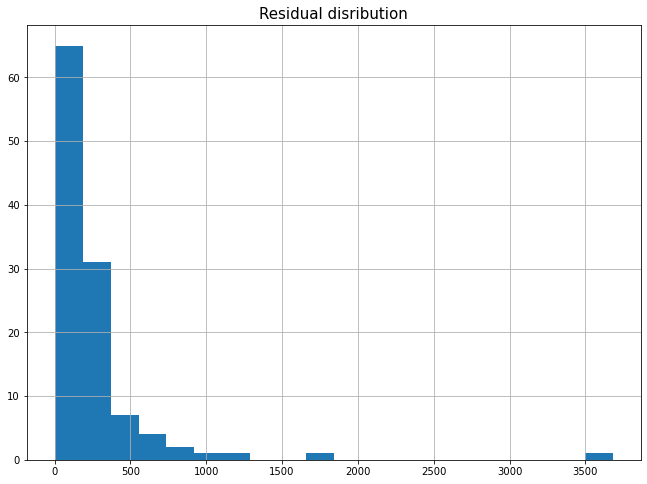

In [1002]:
plt.figure(figsize=(11, 8))
residual.hist(bins=20)
plt.title('Residual disribution', size=15)
plt.show()


This test worked well, we got a normal distribution

### R2 test

In [1003]:
r2_score(y_test, preds)

0.1840021342838476

We got better values than baseline model, but it could be better

### Feature importance

<AxesSubplot:>

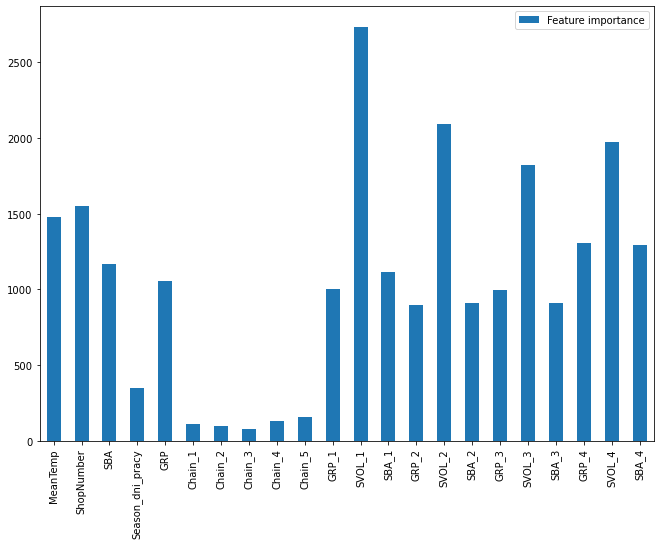

In [1004]:
data = brand1_df.sort_values(by='Week').reset_index()
X = data.drop(columns=['Week', 'SVOL', 'index'])
y = data['SVOL']

model = create_pipe(params)
model.fit(X, y)

features = model[1].get_booster().get_score(importance_type='weight')

pd.DataFrame(
    features.values(),
    index=X.columns,
    columns=['Feature importance']
).plot(kind='bar', figsize=(11, 8))

Previous SVOL values has the biggest impact on current result, maybe we shoud drop it

## Summary

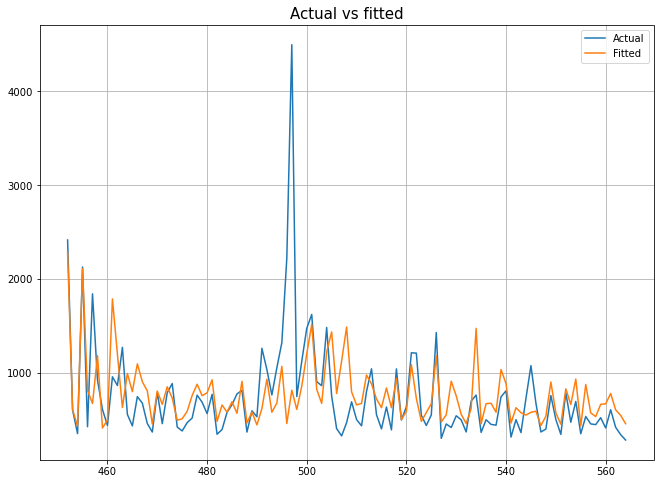

In [1010]:
X_train, X_test, y_train, y_test = prepare_data(brand1_df)
pipe = create_pipe(params)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

plt.figure(figsize=(11, 8))
plt.grid()
plt.plot(X_test.index, y_test)
plt.plot(X_test.index, y_pred)
plt.legend(['Actual', 'Fitted'])
plt.title('Actual vs fitted', size=15)
plt.show()

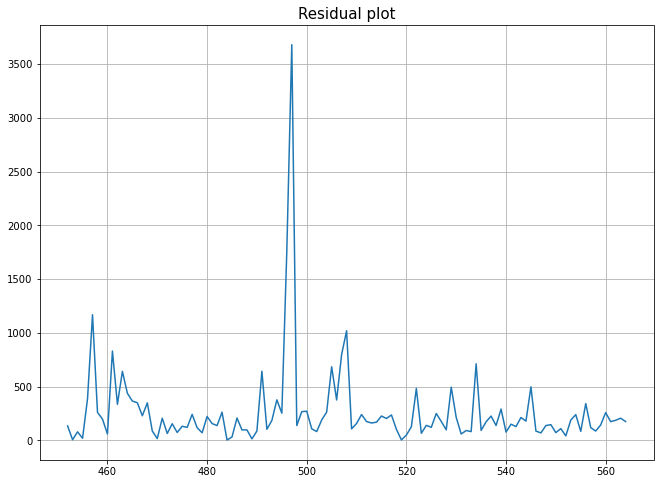

In [1018]:
residual, _, _ = get_residual(brand1_df)

plt.figure(figsize=(11, 8))
residual.plot()
plt.title('Residual plot', size=15)
plt.grid()
plt.show()

Model is not bad, but it could be much better with data from longer time period.

With actual its impossible to predict hight picks.